# The Singular Value Decomposition (SVD)

The singular value decomposition is arguably the most important matrix decomposition in data-driven science. It provides a systematic way to determine a low-dimensional approximation to high-dimensional data in terms of dominant patterns. This notebook covers the theory and computation of the SVD, following the intuition from Chapter 1 of *Data-Driven Science and Engineering* by Brunton and Kutz.

## Why the SVD?

In Earth sciences (and science more broadly), we often collect large datasets that have some underlying structure. Think of a gridded temperature field measured over time, a collection of satellite images, or a set of seismograms recorded at many stations. These datasets are high-dimensional, but the interesting dynamics are often governed by only a few key patterns.

The SVD gives us a principled way to:
1. Discover the dominant patterns in a dataset
2. Rank those patterns by importance
3. Provide an optimal low-rank approximation to the data (i.e. a compressed representation)

It is the mathematical backbone behind techniques like Principal Component Analysis (PCA), Empirical Orthogonal Functions (EOFs), and many dimensionality reduction methods used throughout the geosciences.

In [66]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
np.set_printoptions(precision=4, suppress=True)

rng = np.random.default_rng(42)

## The Data Matrix

Before defining the SVD we need a **data matrix** $\mathbf{X}$. Each column of $\mathbf{X}$ represents a single snapshot or measurement in time, and each row represents a particular measurement location or sensor.

Concretely, suppose we measure a quantity (e.g., temperature) at $n$ spatial locations over $m$ time steps. Then our data matrix is:

$$
\mathbf{X} = \begin{bmatrix}
| & | & & | \\
\mathbf{x}_1 & \mathbf{x}_2 & \cdots & \mathbf{x}_m \\
| & | & & |
\end{bmatrix} \in \mathbb{R}^{n \times m}
$$

where each column $\mathbf{x}_k \in \mathbb{R}^n$ is a snapshot of all $n$ sensors at time $k$.

This convention (spatial locations along rows, time along columns) is very common in the dynamical systems and data-driven modeling communities.

## The SVD: Definition

The SVD factorizes any real matrix $\mathbf{X} \in \mathbb{R}^{n \times m}$ into three matrices:

$$
\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T
$$

where:
- $\mathbf{U} \in \mathbb{R}^{n \times n}$ is an orthogonal matrix whose columns are called the **left singular vectors**
- $\boldsymbol{\Sigma} \in \mathbb{R}^{n \times m}$ is a diagonal matrix (with non-negative entries) containing the **singular values** $\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_p \geq 0$, where $p = \min(n, m)$
- $\mathbf{V} \in \mathbb{R}^{m \times m}$ is an orthogonal matrix whose columns are called the **right singular vectors**

The key properties of orthogonal matrices are:
- $\mathbf{U}^T \mathbf{U} = \mathbf{U} \mathbf{U}^T = \mathbf{I}_n$
- $\mathbf{V}^T \mathbf{V} = \mathbf{V} \mathbf{V}^T = \mathbf{I}_m$

In other words, the columns of $\mathbf{U}$ form an orthonormal basis for $\mathbb{R}^n$, and the columns of $\mathbf{V}$ form an orthonormal basis for $\mathbb{R}^m$.

## A quick note on the matrix dimensions
You should note that $\mathbf{U}$ is $n \times n$ and $\mathbf{V}$ is $m \times m$, which means they are square matrices. However, the original data matrix $\mathbf{X}$ can be rectangular (i.e., $n \neq m$). The SVD still works regardless of the shape of $\mathbf{X}$, and the singular values in $\boldsymbol{\Sigma}$ will reflect the effective rank of the data. This leads to the concept of low-rank approximations, which we will discuss later, but also the "economy SVD" which only computes the first $p$ columns of $\mathbf{U}$ and $\mathbf{V}$ corresponding to the non-zero singular values.

<div style="text-align:center;">
<img src="../../assets/svd_dims.png" width="500" alt="Description of the image">
</div>

## Computing the SVD from "scratch"
The SVD can be computed from the eigen-decomposition of $\mathbf{X}^T \mathbf{X}$ or $\mathbf{X} \mathbf{X}^T$. For example, the right singular vectors $\mathbf{V}$ are the eigenvectors of $\mathbf{X}^T \mathbf{X}$, and the left singular vectors $\mathbf{U}$ are the eigenvectors of $\mathbf{X} \mathbf{X}^T$. The singular values $\sigma_k$ are the square roots of the non-zero eigenvalues. However, in practice we use optimized numerical algorithms (like the Golub-Kahan bidiagonalization) to compute the SVD efficiently and accurately, especially for large matrices.

In code, the naive way to compute the SVD is:

In [67]:
def naive_svd(X):
    # Compute X^T X and its eigen-decomposition
    XtX = X.T @ X
    eigenvalues, V = np.linalg.eig(XtX)
    # Sort eigenvalues and corresponding eigenvectors
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    V = V[:, idx]
    # Compute singular values
    sigma = np.sqrt(eigenvalues)
    # Compute U using X V = U Sigma
    U = X @ V / sigma
    return U, sigma, V

## Interpreting the SVD

### Left singular vectors ($\mathbf{U}$): Spatial patterns
The columns of $\mathbf{U}$ are the **spatial modes** or **patterns** in the data. Each column $\mathbf{u}_k$ has the same dimension as a single snapshot ($n$ entries, one per sensor/spatial location). These modes form an orthonormal hierarchy of spatial patterns present in the data, ordered by importance.

### Singular values ($\boldsymbol{\Sigma}$): Importance
The singular values $\sigma_k$ tell us how important each corresponding mode is. They are always non-negative and ordered from largest to smallest: $\sigma_1 \geq \sigma_2 \geq \cdots \geq 0$. A large singular value means that the corresponding mode captures a large amount of the variance in the data.

### Right singular vectors ($\mathbf{V}$): Temporal coefficients
The columns of $\mathbf{V}$ tell us **how each spatial mode evolves in time**. Each column $\mathbf{v}_k$ has $m$ entries (one per time step), giving the time-dependent coefficient for the $k$-th mode.

So the SVD is telling us that the data $\mathbf{X}$ can be written as a weighted sum of rank-1 matrices, each of which is an outer product of a spatial pattern ($\mathbf{u}_k$) and a temporal pattern ($\mathbf{v}_k$), weighted by the singular value ($\sigma_k$):

$$
\mathbf{X} = \sum_{k=1}^{p} \sigma_k \, \mathbf{u}_k \, \mathbf{v}_k^T
$$

This is a useful decomposition: it separates the data into spatial patterns, their importance, and their time evolution.

## Geometric Interpretation

The SVD also has a clean geometric interpretation. Any linear transformation (represented by a matrix) can be decomposed into three simpler operations:

1. **Rotation/reflection** ($\mathbf{V}^T$): Rotate the input coordinates
2. **Scaling** ($\boldsymbol{\Sigma}$): Stretch or compress along each axis by the singular values
3. **Rotation/reflection** ($\mathbf{U}$): Rotate the output coordinates

This means that any matrix, no matter how complicated, is fundamentally just a rotation, a scaling, and another rotation.

To make this concrete, let's think about **data**. Suppose we have a cloud of 2D points drawn from a correlated Gaussian distribution — an elongated blob tilted at some angle. The SVD of the data matrix finds:
- The **directions** of maximum and minimum spread (the principal axes of the ellipse)
- The **amount** of spread along each direction (the singular values)

This is the geometric heart of PCA: the SVD rotates the data so that the axes align with the directions of greatest variance, then tells you how much variance there is along each axis. Let's visualize this with a concrete example.

## Visualizing the SVD decomposition of a point cloud step by step

1. The SVD says: $\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$
2. So: $\mathbf{U}^T \mathbf{X} = \boldsymbol{\Sigma} \mathbf{V}^T$ (rotate data into principal axes)
3. And: $\boldsymbol{\Sigma}^{-1} \mathbf{U}^T \mathbf{X} = \mathbf{V}^T$ (also rescale — now isotropic)

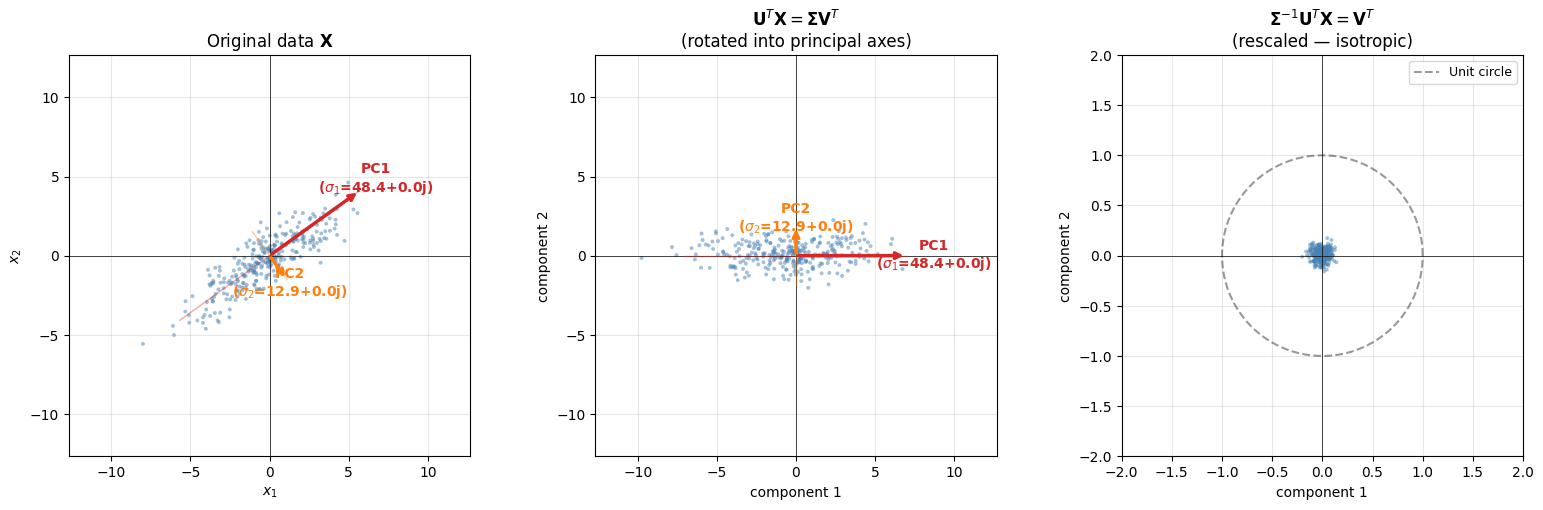

In [89]:
# Generate a correlated 2D point cloud (elongated ellipse, tilted)
rng = np.random.default_rng(7)
n_pts = 300
theta_rot = np.pi / 5  # tilt angle

# Uncorrelated data with different variances along each axis
s1, s2 = 3.0, 0.8
Z = np.diag([s1, s2]) @ rng.standard_normal((2, n_pts))

# Rotate to create correlation
R = np.array([[np.cos(theta_rot), -np.sin(theta_rot)],
              [np.sin(theta_rot),  np.cos(theta_rot)]])
X_cloud = R @ Z  # shape (2, n_pts)

# Compute SVD of the point cloud
U_c, s_c, Vt_c = naive_svd(X_cloud)

# Three stages of the SVD decomposition applied to data:
# Stage 1: Original data X with principal axes overlaid
# Stage 2: U^T X = Sigma V^T  (rotated into principal axes)
# Stage 3: Sigma^{-1} U^T X = V^T  (rescaled to isotropic)
stage1 = X_cloud
stage2 = U_c.T @ X_cloud            # = Sigma @ Vt
stage3 = np.diag(1 / s_c) @ stage2  # = Vt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titles = [
    r'Original data $\mathbf{X}$',
    r'$\mathbf{U}^T \mathbf{X} = \mathbf{\Sigma}\mathbf{V}^T$'
    '\n(rotated into principal axes)',
    r'$\mathbf{\Sigma}^{-1}\mathbf{U}^T \mathbf{X} = \mathbf{V}^T$'
    '\n(rescaled — isotropic)'
]

for ax, data, title in zip(axes, [stage1, stage2, stage3], titles):
    ax.scatter(data[0], data[1], s=8, alpha=0.5, color='steelblue', edgecolors='none')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color='k', linewidth=0.5)
    ax.axvline(0, color='k', linewidth=0.5)
    ax.set_title(title, fontsize=12)

# --- Visual scale for arrows: use standard deviations along each PC ---
# sigma_k / sqrt(n) gives the std dev along PC k
std_pc = s_c / np.sqrt(n_pts)
arrow_scale = 2.5  # draw arrows at ±2.5 standard deviations
pc_colors = ['C3', 'C1']
pc_labels = ['PC1', 'PC2']

# Stage 1: principal axes overlaid on the tilted cloud
origin = np.zeros(2)
for k in range(2):
    tip = arrow_scale * std_pc[k] * U_c[:, k]
    # Draw line spanning both directions (±)
    axes[0].plot([-tip[0], tip[0]], [-tip[1], tip[1]],
                 color=pc_colors[k], linewidth=1, alpha=0.4)
    # Arrow from origin to +direction
    axes[0].annotate('', xy=tip, xytext=origin,
                     arrowprops=dict(arrowstyle='->', color=pc_colors[k], lw=2.5))
    axes[0].text(tip[0] * 1.18, tip[1] * 1.18,
                 f'{pc_labels[k]}\n($\\sigma_{k+1}$={s_c[k]:.1f})',
                 fontsize=10, color=pc_colors[k], fontweight='bold',
                 ha='center', va='center')

# Stage 2: axes aligned with coordinate axes after rotation by U^T
for k in range(2):
    tip = np.zeros(2)
    tip[k] = arrow_scale * std_pc[k]
    # Line spanning both directions
    neg_tip = np.zeros(2)
    neg_tip[k] = -arrow_scale * std_pc[k]
    axes[1].plot([neg_tip[0], tip[0]], [neg_tip[1], tip[1]],
                 color=pc_colors[k], linewidth=1, alpha=0.4)
    # Arrow from origin
    axes[1].annotate('', xy=tip, xytext=origin,
                     arrowprops=dict(arrowstyle='->', color=pc_colors[k], lw=2.5))
    offset = tip * 1.25
    axes[1].text(offset[0], offset[1],
                 f'{pc_labels[k]}\n($\\sigma_{k+1}$={s_c[k]:.1f})',
                 fontsize=10, color=pc_colors[k], fontweight='bold',
                 ha='center', va='center')

# Stage 3: draw unit circle
theta_circ = np.linspace(0, 2 * np.pi, 200)
axes[2].plot(np.cos(theta_circ), np.sin(theta_circ), 'k--', alpha=0.4, linewidth=1.5,
             label='Unit circle')
axes[2].legend(fontsize=9, loc='upper right')

# Set axis limits
lim = max(np.abs(X_cloud).max(), np.abs(stage2).max()) * 1.3
axes[0].set_xlim(-lim, lim); axes[0].set_ylim(-lim, lim)
axes[1].set_xlim(-lim, lim); axes[1].set_ylim(-lim, lim)
axes[2].set_xlim(-2, 2); axes[2].set_ylim(-2, 2)

axes[0].set_xlabel('$x_1$'); axes[0].set_ylabel('$x_2$')
axes[1].set_xlabel('component 1'); axes[1].set_ylabel('component 2')
axes[2].set_xlabel('component 1'); axes[2].set_ylabel('component 2')

plt.tight_layout()

## Computing the SVD in NumPy to reveal the underlying structure of a synthetic dataset

NumPy provides a straightforward way to compute the SVD via `np.linalg.svd`. First, let's check how the numpy version compares to the naive impelementation from before. Re-using the same synthetic data matrix, we can compute the SVD using NumPy and verify that it matches our manual computation.

In [69]:
# Compare our naive SVD with NumPy's implementation on a small test matrix
rng_test = np.random.default_rng(0)
A_test = rng_test.standard_normal((6, 4))

U_naive, s_naive, V_naive = naive_svd(A_test)
U_np, s_np, Vt_np = np.linalg.svd(A_test, full_matrices=False)

print("Singular values:")
print(f"  Naive:  {s_naive}")
print(f"  NumPy:  {s_np}")
print(f"  Match:  {np.allclose(s_naive, s_np)}")

# Note: singular vectors may differ by a sign flip — compare absolute values
print(f"\nLeft singular vectors match (up to sign):  "
      f"{np.allclose(np.abs(U_naive), np.abs(U_np))}")
print(f"Right singular vectors match (up to sign): "
      f"{np.allclose(np.abs(V_naive), np.abs(Vt_np.T))}")

Singular values:
  Naive:  [3.0361 2.0335 1.8563 0.8954]
  NumPy:  [3.0361 2.0335 1.8563 0.8954]
  Match:  True

Left singular vectors match (up to sign):  True
Right singular vectors match (up to sign): True


## Working with a more interesting synthetic dataset

Next, let's build a synthetic data matrix to work with. We'll create data that has a known low-rank structure so that we can see how the SVD recovers it. This is just a simple example, but it will illustrate the power of the SVD to uncover underlying patterns in data.

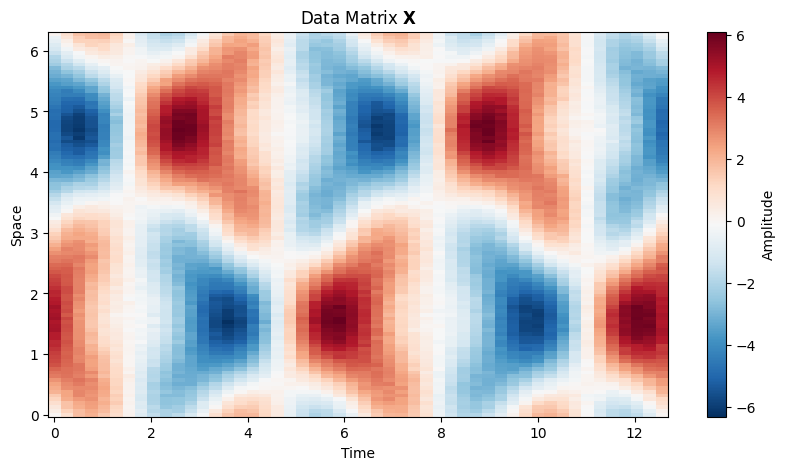

In [70]:
# Create a synthetic data matrix with known low-rank structure
n = 100  # number of spatial locations
m = 50   # number of time steps

x = np.linspace(0, 2 * np.pi, n)  # spatial coordinate
t = np.linspace(0, 4 * np.pi, m)  # temporal coordinate

# Build data from 3 known modes:
# Mode 1: a strong sine wave that oscillates slowly in time
mode1 = np.outer(np.sin(x), np.cos(t))  # rank-1, large amplitude

# Mode 2: a higher frequency spatial pattern with different temporal behavior
mode2 = np.outer(np.cos(2 * x), np.sin(2 * t))  # rank-1, medium amplitude

# Mode 3: a weak localized pattern
mode3 = np.outer(np.exp(-(x - np.pi)**2), np.cos(3 * t))  # rank-1, small amplitude

# Combine with different weights to set importance
X = 5 * mode1 + 2 * mode2 + 0.5 * mode3

# Add a small amount of noise
rng = np.random.default_rng(42)
X += 0.1 * rng.standard_normal(X.shape)

# Visualize the data matrix
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.pcolormesh(t, x, X, cmap='RdBu_r', shading='auto')
ax.set_xlabel('Time')
ax.set_ylabel('Space')
ax.set_title('Data Matrix $\mathbf{X}$')
plt.colorbar(im, ax=ax, label='Amplitude')

In [71]:
# Compute the SVD
U, s, Vt = np.linalg.svd(X, full_matrices=True)

print(f"U shape:  {U.shape}   (n x n = {n} x {n})")
print(f"s shape:  {s.shape}   ({min(n,m)} singular values)")
print(f"Vt shape: {Vt.shape}  (m x m = {m} x {m})")
print(f"\nFirst 10 singular values: {s[:10]}")

U shape:  (100, 100)   (n x n = 100 x 100)
s shape:  (50,)   (50 singular values)
Vt shape: (50, 50)  (m x m = 50 x 50)

First 10 singular values: [177.7189  70.6709  10.6638   1.5914   1.5674   1.5124   1.4517   1.4073
   1.3712   1.3536]


### Full vs. Economy SVD

The full SVD computes all $n$ columns of $\mathbf{U}$ and all $m$ columns of $\mathbf{V}$, but many of these correspond to zero singular values. In practice, we often only need the first $p = \min(n, m)$ modes. This is called the **economy SVD** (or thin SVD):

$$
\mathbf{X} = \hat{\mathbf{U}} \hat{\boldsymbol{\Sigma}} \hat{\mathbf{V}}^T
$$

where $\hat{\mathbf{U}} \in \mathbb{R}^{n \times p}$, $\hat{\boldsymbol{\Sigma}} \in \mathbb{R}^{p \times p}$, and $\hat{\mathbf{V}} \in \mathbb{R}^{m \times p}$.

In NumPy, set `full_matrices=False` to get the economy SVD:

In [72]:
U_econ, s_econ, Vt_econ = np.linalg.svd(X, full_matrices=False)

print(f"Economy SVD shapes:")
print(f"  U:  {U_econ.shape}  (n x p = {n} x {min(n,m)})")
print(f"  s:  {s_econ.shape}")
print(f"  Vt: {Vt_econ.shape} (p x m = {min(n,m)} x {m})")

Economy SVD shapes:
  U:  (100, 50)  (n x p = 100 x 50)
  s:  (50,)
  Vt: (50, 50) (p x m = 50 x 50)


### Verifying the decomposition

Let's check that the SVD actually reconstructs the original matrix, and that $\mathbf{U}$ and $\mathbf{V}$ are indeed orthogonal.

In [73]:
# Reconstruct X from the economy SVD
X_reconstructed = U_econ @ np.diag(s_econ) @ Vt_econ

reconstruction_error = np.linalg.norm(X - X_reconstructed) / np.linalg.norm(X)
print(f"Relative reconstruction error: {reconstruction_error:.2e}")

# Check orthogonality of U
UtU = U_econ.T @ U_econ
print(f"\n||U^T U - I|| = {np.linalg.norm(UtU - np.eye(min(n,m))):.2e}")

# Check orthogonality of V
VtV = Vt_econ @ Vt_econ.T
print(f"||V^T V - I|| = {np.linalg.norm(VtV - np.eye(min(n,m))):.2e}")

Relative reconstruction error: 9.34e-16

||U^T U - I|| = 1.27e-14
||V^T V - I|| = 1.27e-14


## Visualizing the SVD Components

Now let's look at the spatial modes ($\mathbf{U}$), singular values ($\boldsymbol{\Sigma}$), and temporal modes ($\mathbf{V}$) that the SVD found.

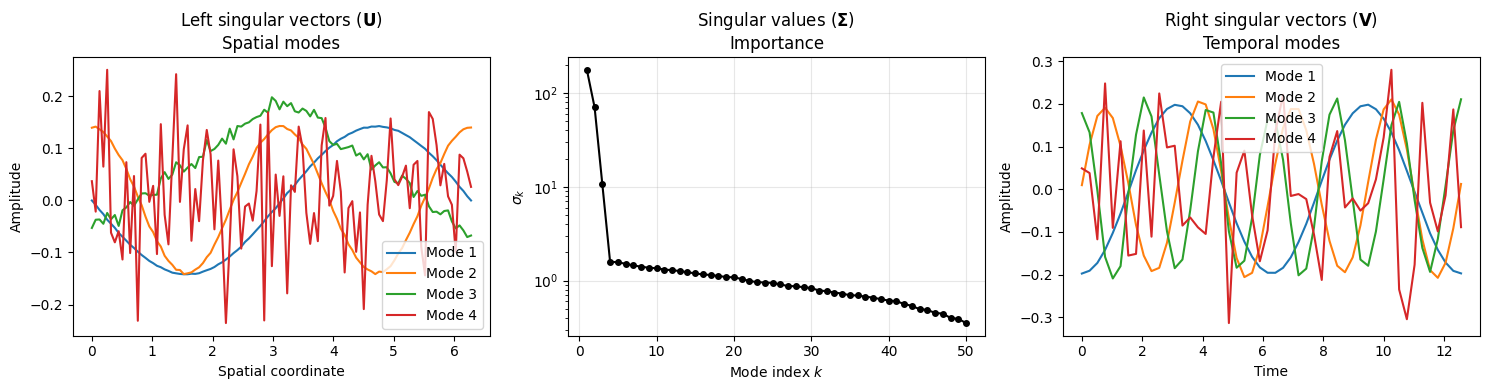

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Spatial modes (columns of U)
for k in range(4):
    axes[0].plot(x, U_econ[:, k], label=f'Mode {k+1}')
axes[0].set_xlabel('Spatial coordinate')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Left singular vectors ($\mathbf{U}$)\nSpatial modes')
axes[0].legend()

# Singular values
axes[1].semilogy(np.arange(1, len(s_econ) + 1), s_econ, 'ko-', markersize=4)
axes[1].set_xlabel('Mode index $k$')
axes[1].set_ylabel('$\sigma_k$')
axes[1].set_title('Singular values ($\mathbf{\Sigma}$)\nImportance')
axes[1].grid(True, alpha=0.3)

# Temporal modes (rows of V^T = columns of V)
for k in range(4):
    axes[2].plot(t, Vt_econ[k, :], label=f'Mode {k+1}')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Amplitude')
axes[2].set_title('Right singular vectors ($\mathbf{V}$)\nTemporal modes')
axes[2].legend()

plt.tight_layout()

Notice a few things:
- The first spatial mode (blue) looks like $\sin(x)$, matching our dominant mode
- The second spatial mode (orange) looks like $\cos(2x)$, matching our second mode
- The singular value spectrum drops off sharply after 3 modes, reflecting that our data is built from 3 clean modes plus noise
- The temporal modes show the corresponding time behavior for each spatial pattern

The SVD has successfully recovered the structure we built into the data!

## The Truncated SVD and Low-Rank Approximation

One of the most powerful properties of the SVD is that it provides the **optimal low-rank approximation** to a matrix. This is formalized by the **Eckart-Young-Mirsky theorem**:

> The best rank-$r$ approximation to $\mathbf{X}$ (in both the 2-norm and the Frobenius norm) is obtained by keeping only the first $r$ terms of the SVD:
>
> $$\tilde{\mathbf{X}}_r = \sum_{k=1}^{r} \sigma_k \, \mathbf{u}_k \, \mathbf{v}_k^T = \mathbf{U}_r \boldsymbol{\Sigma}_r \mathbf{V}_r^T$$

No other rank-$r$ matrix is closer to $\mathbf{X}$. This is a remarkable result: the SVD automatically gives us the best possible compression of our data for any given rank.

The approximation error is:
$$\|\mathbf{X} - \tilde{\mathbf{X}}_r\|_F = \sqrt{\sigma_{r+1}^2 + \sigma_{r+2}^2 + \cdots + \sigma_p^2}$$

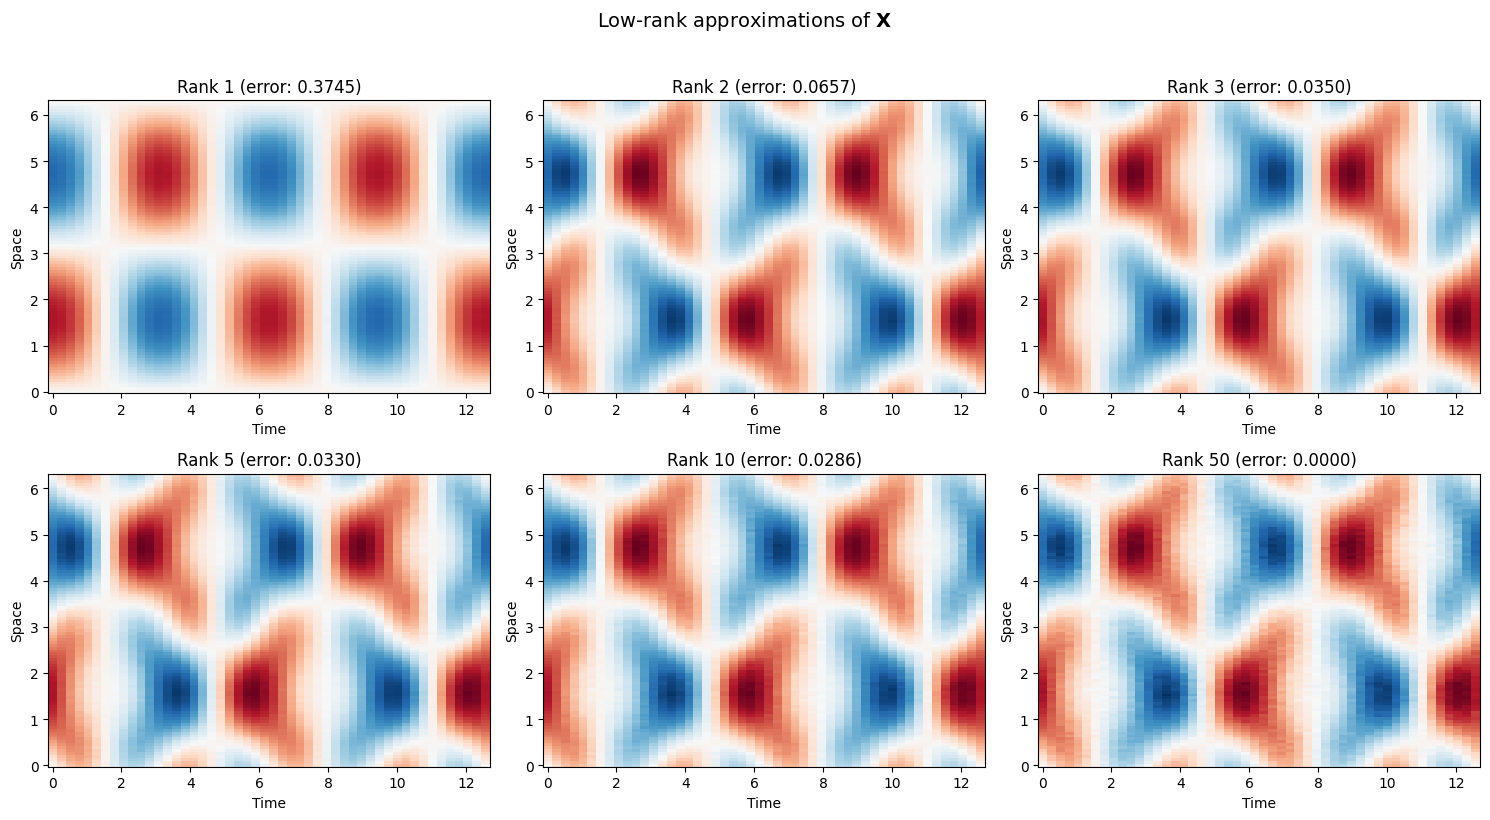

In [75]:
# Demonstrate low-rank approximations
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

ranks = [1, 2, 3, 5, 10, min(n, m)]  # different truncation ranks
vmin, vmax = X.min(), X.max()

for ax, r in zip(axes.flat, ranks):
    # Truncated SVD reconstruction
    X_r = U_econ[:, :r] @ np.diag(s_econ[:r]) @ Vt_econ[:r, :]
    
    rel_error = np.linalg.norm(X - X_r, 'fro') / np.linalg.norm(X, 'fro')
    
    im = ax.pcolormesh(t, x, X_r, cmap='RdBu_r', shading='auto',
                       vmin=vmin, vmax=vmax)
    ax.set_title(f'Rank {r} (error: {rel_error:.4f})')
    ax.set_xlabel('Time')
    ax.set_ylabel('Space')

plt.suptitle('Low-rank approximations of $\mathbf{X}$', fontsize=14, y=1.02)
plt.tight_layout()

## Cumulative Energy and Choosing the Rank

How do we choose the truncation rank $r$? One common approach is to look at the **cumulative energy** captured by the first $r$ modes. The energy (variance) captured by each mode is proportional to $\sigma_k^2$, so the fraction of total energy captured by the first $r$ modes is:

$$
\text{Energy}(r) = \frac{\sum_{k=1}^{r} \sigma_k^2}{\sum_{k=1}^{p} \sigma_k^2}
$$

A common rule of thumb is to keep enough modes to capture 90% or 99% of the total energy.

90% energy captured by first 2 modes
95% energy captured by first 2 modes
99% energy captured by first 2 modes


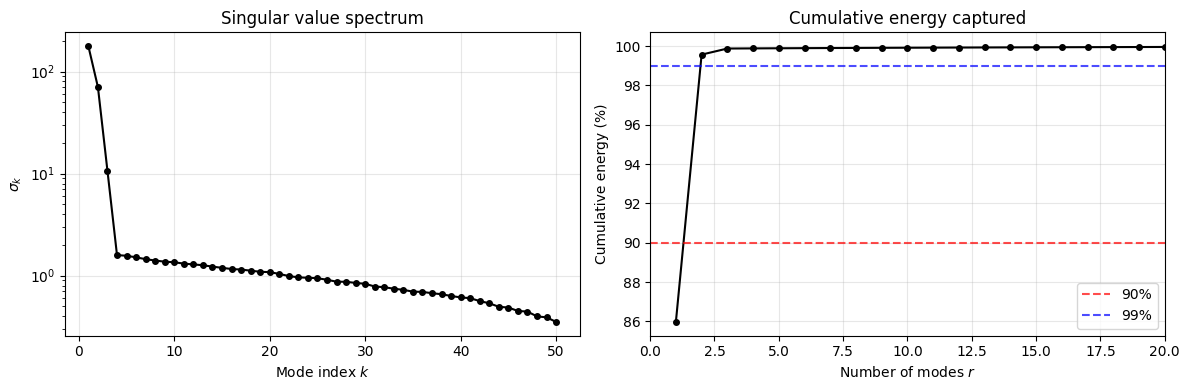

In [76]:
# Compute cumulative energy
energy = s_econ**2
cumulative_energy = np.cumsum(energy) / np.sum(energy)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Singular value spectrum
axes[0].semilogy(np.arange(1, len(s_econ)+1), s_econ, 'ko-', markersize=4)
axes[0].set_xlabel('Mode index $k$')
axes[0].set_ylabel('$\sigma_k$')
axes[0].set_title('Singular value spectrum')
axes[0].grid(True, alpha=0.3)

# Cumulative energy
axes[1].plot(np.arange(1, len(s_econ)+1), cumulative_energy * 100, 'ko-', markersize=4)
axes[1].axhline(90, color='r', linestyle='--', alpha=0.7, label='90%')
axes[1].axhline(99, color='b', linestyle='--', alpha=0.7, label='99%')
axes[1].set_xlabel('Number of modes $r$')
axes[1].set_ylabel('Cumulative energy (%)')
axes[1].set_title('Cumulative energy captured')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 20)

plt.tight_layout()

# Print how many modes for different thresholds
for threshold in [0.90, 0.95, 0.99]:
    r = np.argmax(cumulative_energy >= threshold) + 1
    print(f"{threshold*100:.0f}% energy captured by first {r} modes")

## Connection to the Eigendecomposition

The SVD is closely related to the eigendecomposition of two important matrices. Consider $\mathbf{X} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$. Then:

### The correlation matrix $\mathbf{X}^T \mathbf{X}$

$$
\mathbf{X}^T \mathbf{X} = (\mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T)^T (\mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T) = \mathbf{V} \boldsymbol{\Sigma}^T \mathbf{U}^T \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T = \mathbf{V} \boldsymbol{\Sigma}^2 \mathbf{V}^T
$$

So the right singular vectors $\mathbf{V}$ are the eigenvectors of $\mathbf{X}^T \mathbf{X}$, and the eigenvalues are $\sigma_k^2$.

### The covariance-like matrix $\mathbf{X} \mathbf{X}^T$

$$
\mathbf{X} \mathbf{X}^T = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T \mathbf{V} \boldsymbol{\Sigma}^T \mathbf{U}^T = \mathbf{U} \boldsymbol{\Sigma}^2 \mathbf{U}^T
$$

So the left singular vectors $\mathbf{U}$ are the eigenvectors of $\mathbf{X} \mathbf{X}^T$, and again the eigenvalues are $\sigma_k^2$.

This connection is important because:
- It shows that the SVD generalizes the eigendecomposition to non-square matrices
- It connects the SVD to Principal Component Analysis (PCA), which is the eigendecomposition of the covariance matrix
- In Earth sciences, these eigenvectors are often called **Empirical Orthogonal Functions (EOFs)**

In [77]:
# Verify the connection between SVD and eigendecomposition
# Eigendecomposition of X^T X
XtX = X.T @ X
eigenvalues, eigenvectors = np.linalg.eigh(XtX)

# eigh returns eigenvalues in ascending order, so flip
eigenvalues = eigenvalues[::-1]
eigenvectors = eigenvectors[:, ::-1]

print("Comparing eigenvalues of X^T X with sigma^2:")
print(f"{'Eigenvalue':>15s}  {'sigma^2':>15s}  {'Difference':>15s}")
for i in range(5):
    print(f"{eigenvalues[i]:15.6f}  {s_econ[i]**2:15.6f}  {abs(eigenvalues[i] - s_econ[i]**2):15.2e}")

Comparing eigenvalues of X^T X with sigma^2:
     Eigenvalue          sigma^2       Difference
   31583.991788     31583.991788         4.37e-11
    4994.380408      4994.380408         9.09e-12
     113.716055       113.716055         2.70e-13
       2.532455         2.532455         1.83e-13
       2.456588         2.456588         9.10e-14


## The Rank-1 Expansion: Building Up the Data

To really drive home the interpretation, let's visualize how the data is built up mode by mode. Recall:

$$
\mathbf{X} = \sigma_1 \mathbf{u}_1 \mathbf{v}_1^T + \sigma_2 \mathbf{u}_2 \mathbf{v}_2^T + \sigma_3 \mathbf{u}_3 \mathbf{v}_3^T + \cdots
$$

Each term $\sigma_k \mathbf{u}_k \mathbf{v}_k^T$ is a rank-1 matrix (an outer product).

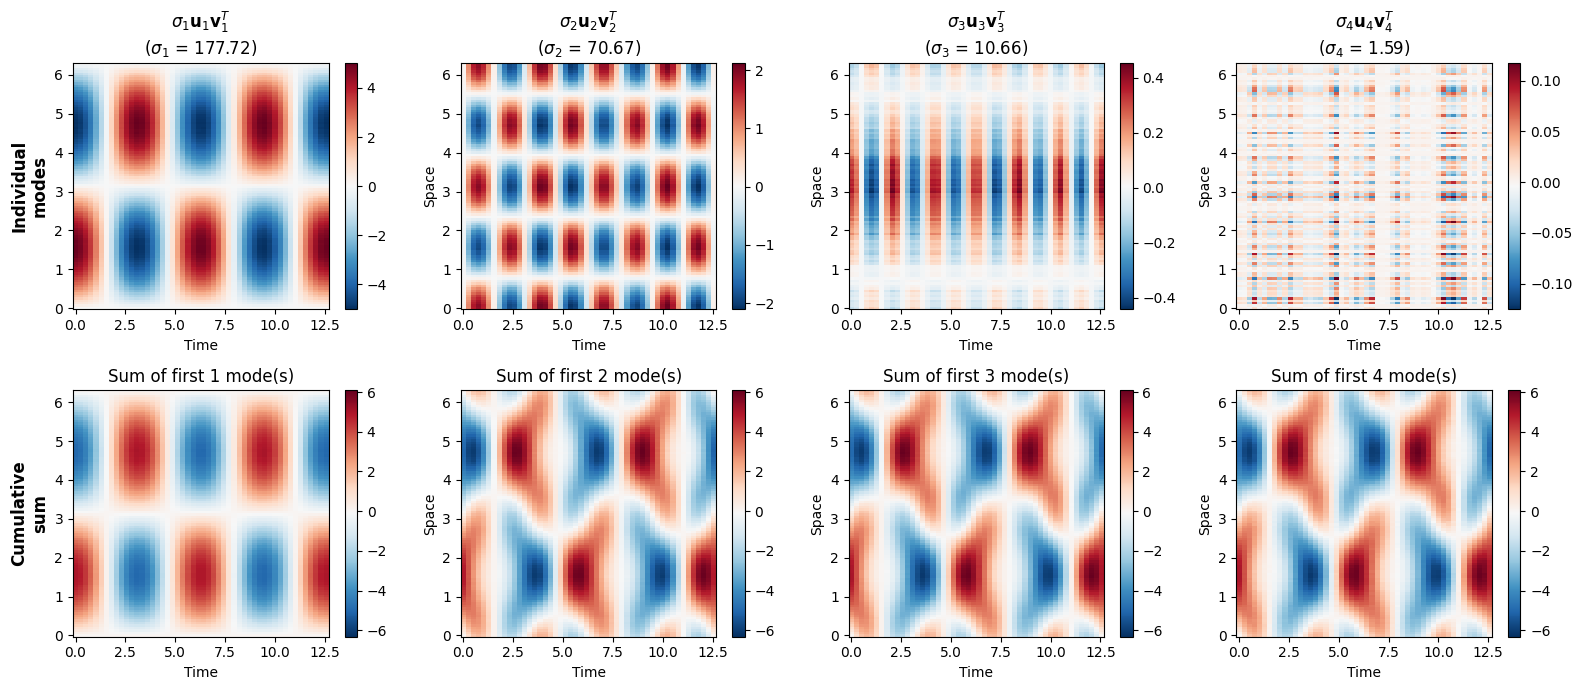

In [78]:
fig, axes = plt.subplots(2, 4, figsize=(16, 7))

# Top row: individual rank-1 components
for k in range(4):
    component = s_econ[k] * np.outer(U_econ[:, k], Vt_econ[k, :])
    im = axes[0, k].pcolormesh(t, x, component, cmap='RdBu_r', shading='auto')
    axes[0, k].set_title(f'$\sigma_{k+1} \mathbf{{u}}_{k+1} \mathbf{{v}}_{k+1}^T$\n($\sigma_{k+1}$ = {s_econ[k]:.2f})')
    axes[0, k].set_xlabel('Time')
    axes[0, k].set_ylabel('Space')
    plt.colorbar(im, ax=axes[0, k])

# Bottom row: cumulative sum
cumulative = np.zeros_like(X)
for k in range(4):
    cumulative += s_econ[k] * np.outer(U_econ[:, k], Vt_econ[k, :])
    im = axes[1, k].pcolormesh(t, x, cumulative, cmap='RdBu_r', shading='auto',
                                vmin=vmin, vmax=vmax)
    axes[1, k].set_title(f'Sum of first {k+1} mode(s)')
    axes[1, k].set_xlabel('Time')
    axes[1, k].set_ylabel('Space')
    plt.colorbar(im, ax=axes[1, k])

axes[0, 0].set_ylabel('Individual\nmodes', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Cumulative\nsum', fontsize=12, fontweight='bold')
plt.tight_layout()

## Summary of Core Theory

The SVD is a fundamental decomposition that:

1. **Exists for any matrix** — unlike the eigendecomposition, the SVD always exists, even for non-square and rank-deficient matrices

2. **Decomposes data into interpretable components** — spatial modes ($\mathbf{U}$), their importance ($\boldsymbol{\Sigma}$), and temporal behavior ($\mathbf{V}$)

3. **Provides optimal low-rank approximations** — the truncated SVD is provably the best possible compression for a given rank (Eckart-Young-Mirsky theorem)

4. **Reveals fundamental matrix properties** — rank, norms, condition number, and subspaces

5. **Connects to many other techniques** — PCA, EOFs, least squares, pseudoinverses, and more

The following sections explore several of these practical applications in more depth, before we move on to applying the SVD to real Earth science datasets in the next notebook.

## Application 1: Image Compression with the SVD

One of the most intuitive demonstrations of the SVD is **image compression**. A grayscale image is just a matrix of pixel intensities, and the truncated SVD gives us the optimal low-rank approximation — a compressed version of the image using far fewer numbers than the original.

This example follows the spirit of the image compression discussion in Chapter 1 of *Data-Driven Science and Engineering* (Brunton & Kutz). The key insight is that natural images tend to have rapidly decaying singular values, meaning a handful of modes capture most of the visual information.

Image shape: (427, 640) (height x width)
Number of singular values: 427


(np.float64(-0.5), np.float64(639.5), np.float64(426.5), np.float64(-0.5))

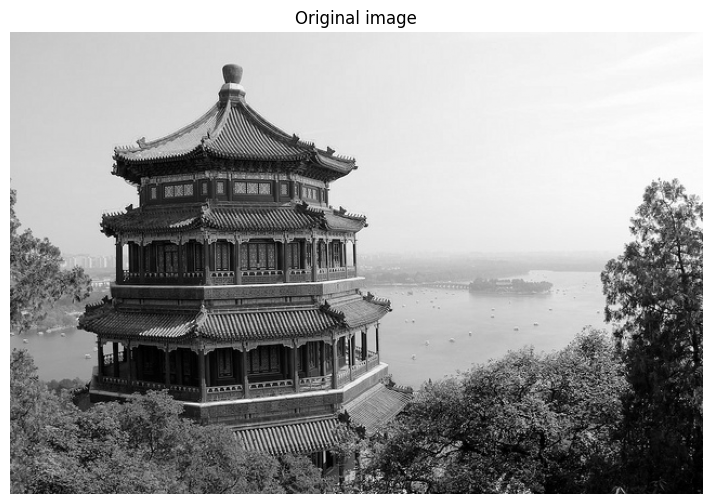

In [79]:
from sklearn.datasets import load_sample_image

# Load a sample image and convert to grayscale
china = load_sample_image("china.jpg")
# Convert to grayscale using luminosity formula
img = np.dot(china[..., :3], [0.2989, 0.5870, 0.1140])
print(f"Image shape: {img.shape} (height x width)")

# Compute SVD
U_img, s_img, Vt_img = np.linalg.svd(img, full_matrices=False)
print(f"Number of singular values: {len(s_img)}")

# Show the original image
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img, cmap="gray")
ax.set_title("Original image")
ax.axis("off")

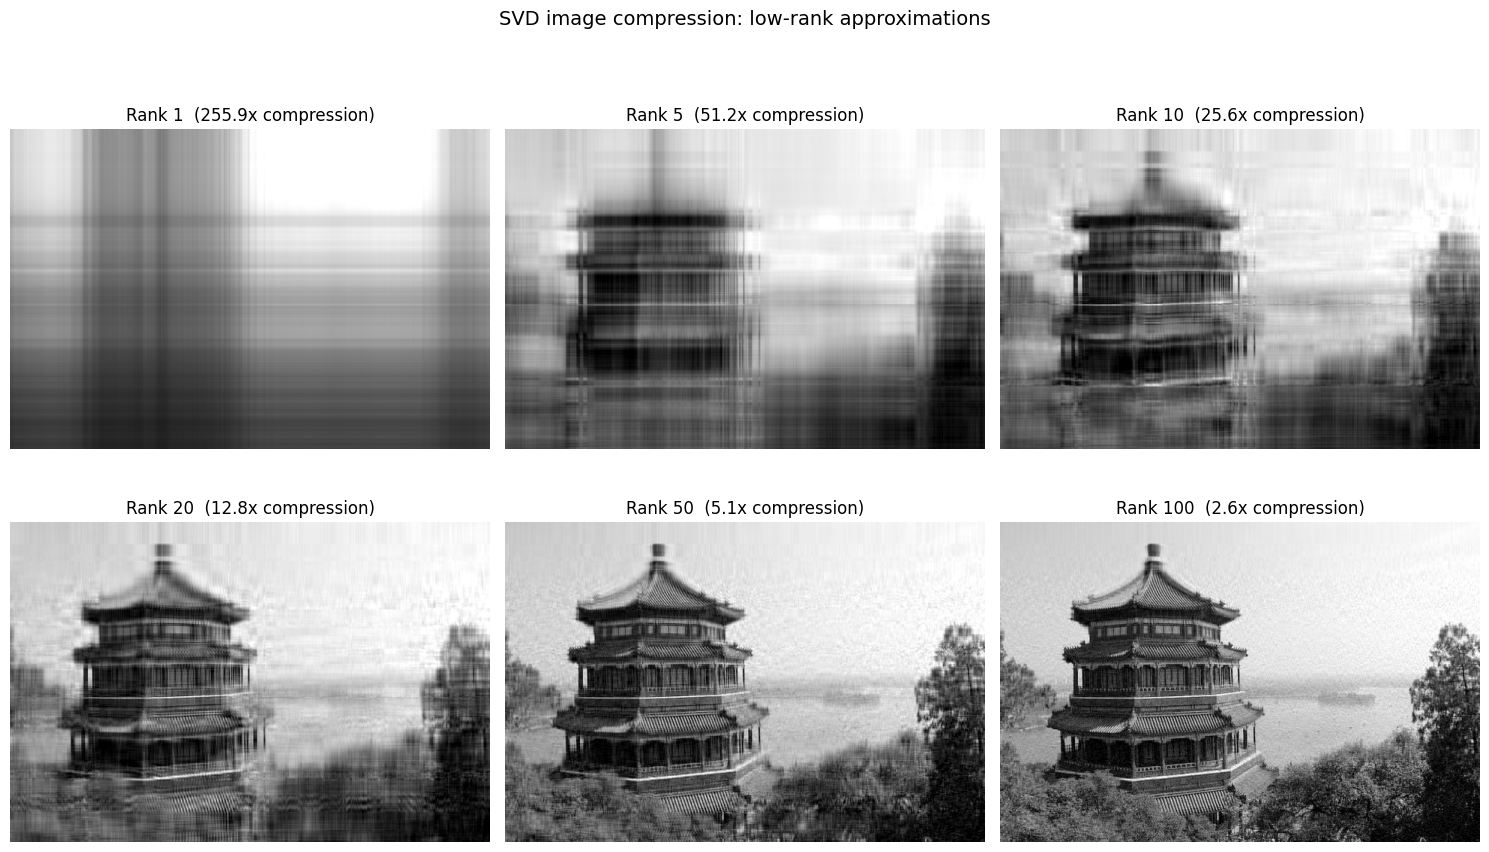

In [80]:
# Low-rank approximations of the image
ranks = [1, 5, 10, 20, 50, 100]
n_rows, n_cols = img.shape
total_entries = n_rows * n_cols

fig, axes = plt.subplots(2, 3, figsize=(15, 9))

for ax, r in zip(axes.flat, ranks):
    img_r = U_img[:, :r] @ np.diag(s_img[:r]) @ Vt_img[:r, :]
    
    # Compression ratio: original stores n*m numbers,
    # rank-r stores r*(n + m + 1) numbers
    compressed_entries = r * (n_rows + n_cols + 1)
    ratio = total_entries / compressed_entries
    
    ax.imshow(img_r, cmap="gray", vmin=img.min(), vmax=img.max())
    ax.set_title(f"Rank {r}  ({ratio:.1f}x compression)")
    ax.axis("off")

plt.suptitle("SVD image compression: low-rank approximations", fontsize=14, y=1.01)
plt.tight_layout()

95% of image energy captured by 3 modes (out of 427)
99% of image energy captured by 56 modes


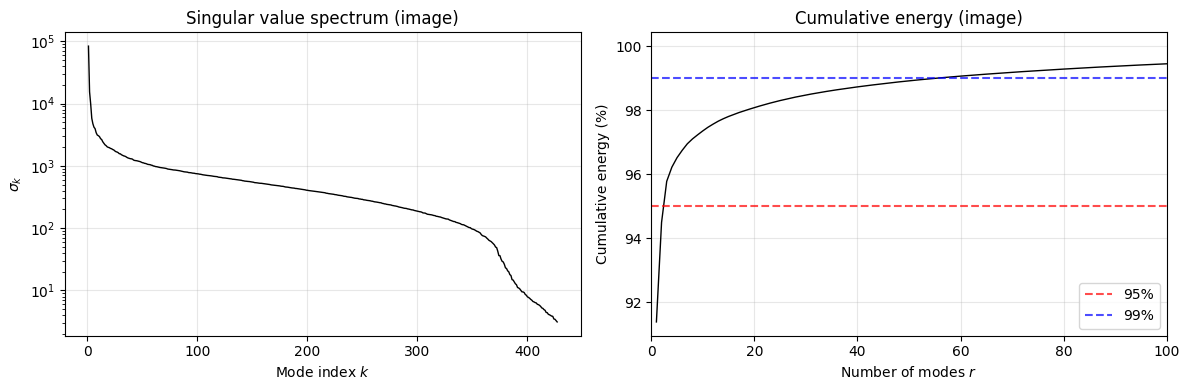

In [81]:
# Singular value spectrum of the image
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].semilogy(np.arange(1, len(s_img) + 1), s_img, 'k-', linewidth=1)
axes[0].set_xlabel("Mode index $k$")
axes[0].set_ylabel("$\\sigma_k$")
axes[0].set_title("Singular value spectrum (image)")
axes[0].grid(True, alpha=0.3)

cumulative_img = np.cumsum(s_img**2) / np.sum(s_img**2)
axes[1].plot(np.arange(1, len(s_img) + 1), cumulative_img * 100, 'k-', linewidth=1)
axes[1].axhline(95, color='r', linestyle='--', alpha=0.7, label='95%')
axes[1].axhline(99, color='b', linestyle='--', alpha=0.7, label='99%')
axes[1].set_xlabel("Number of modes $r$")
axes[1].set_ylabel("Cumulative energy (%)")
axes[1].set_title("Cumulative energy (image)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 100)

plt.tight_layout()

r_95 = np.argmax(cumulative_img >= 0.95) + 1
r_99 = np.argmax(cumulative_img >= 0.99) + 1
print(f"95% of image energy captured by {r_95} modes (out of {len(s_img)})")
print(f"99% of image energy captured by {r_99} modes")

The rapid decay of singular values explains why the SVD is so effective for compression: a small number of modes captures most of the structure. This is the same principle that will allow us to describe complex global climate fields with just a handful of EOFs in the next notebook.

**Connection to Earth science**: Satellite imagery, digital elevation models, and gridded reanalysis fields are all matrices. The SVD can compress them, denoise them, or reveal their dominant structures — the same mathematics applied in different contexts.

## Application 2: Eigenfaces — SVD for Collections of Images

When we apply the SVD not to a *single* image but to a *collection* of images, the left singular vectors become **characteristic spatial patterns** shared across the collection. This is exactly the same idea as EOFs in climate science, but applied to faces instead of temperature fields.

The classic **eigenfaces** method (Turk & Pentland, 1991) was one of the first successful face recognition algorithms. The procedure is:

1. Arrange each face image as a column vector
2. Stack all face vectors into a data matrix $\mathbf{X}$
3. Subtract the mean face
4. Compute the SVD → the left singular vectors are the "eigenfaces"

This is PCA applied to face images — the same decomposition we will apply to sea surface temperature in the next notebook. The parallel is direct:

| Faces | Climate (next notebook) |
|-------|------------------------|
| Each image is a "snapshot" | Each month of SST is a snapshot |
| Pixel locations are the "spatial" dimension | Grid points are the spatial dimension |
| Different faces are the "samples" | Different months are the time steps |
| Eigenfaces = dominant spatial patterns | EOFs = dominant spatial patterns |

In [82]:
from sklearn.datasets import fetch_olivetti_faces

# Load the Olivetti faces dataset (400 faces, 64x64 pixels each)
faces_data = fetch_olivetti_faces()
faces = faces_data.data       # shape: (400, 4096) — each row is a flattened 64x64 face
n_faces, n_pixels = faces.shape
img_h, img_w = 64, 64

print(f"Number of faces: {n_faces}")
print(f"Each face: {img_h} x {img_w} = {n_pixels} pixels")

# Step 1: Compute and subtract the mean face
mean_face = faces.mean(axis=0)
faces_centered = faces - mean_face

# Step 2: Compute SVD
# Convention: faces_centered.T has shape (n_pixels, n_faces) = (space, samples)
U_faces, s_faces, Vt_faces = np.linalg.svd(faces_centered.T, full_matrices=False)

print(f"\nSVD shapes:")
print(f"  U (eigenfaces):  {U_faces.shape}")
print(f"  s (singular values): {s_faces.shape}")
print(f"  Vt (coefficients): {Vt_faces.shape}")

Number of faces: 400
Each face: 64 x 64 = 4096 pixels

SVD shapes:
  U (eigenfaces):  (4096, 400)
  s (singular values): (400,)
  Vt (coefficients): (400, 400)


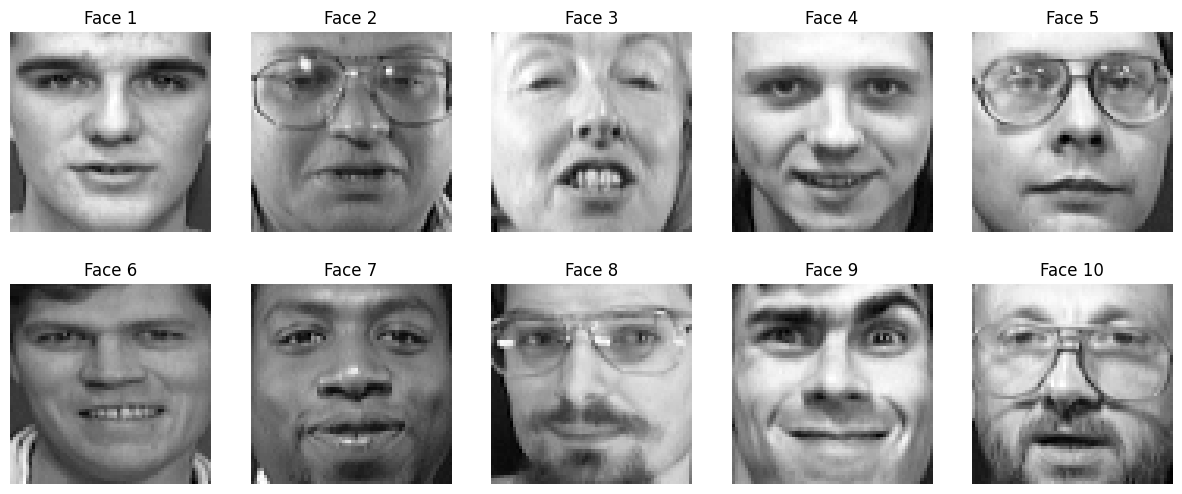

In [83]:
# Add some example faces, chosen randomly in a 2 by 5 grid
indices = np.random.choice(n_faces, size=10, replace=False)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    idx = indices[i]
    ax = axes.flat[i]
    ax.imshow(faces[idx].reshape(img_h, img_w), cmap='gray')
    ax.set_title(f"Face {i+1}")
    ax.axis('off')

Text(0.5, 1.02, 'Mean face and leading eigenfaces (left singular vectors)')

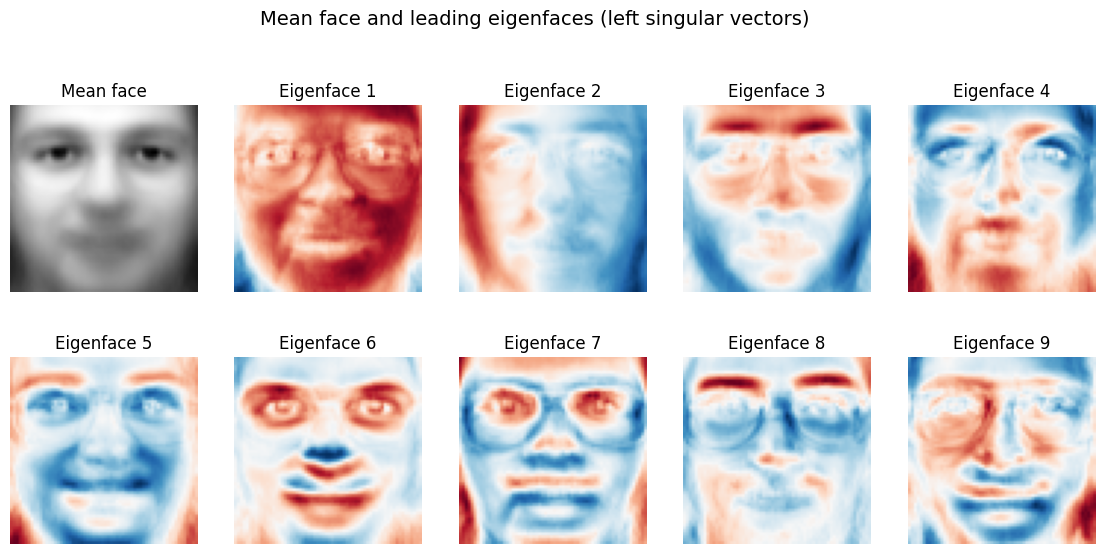

In [84]:
# Visualize the mean face and leading eigenfaces
fig, axes = plt.subplots(2, 5, figsize=(14, 6))

# Mean face
axes[0, 0].imshow(mean_face.reshape(img_h, img_w), cmap="gray")
axes[0, 0].set_title("Mean face")
axes[0, 0].axis("off")

# First 9 eigenfaces (columns of U)
for k in range(9):
    row, col = divmod(k + 1, 5) if k + 1 >= 5 else (0, k + 1)
    eigenface = U_faces[:, k].reshape(img_h, img_w)
    axes[row, col].imshow(eigenface, cmap="RdBu_r")
    axes[row, col].set_title(f"Eigenface {k+1}")
    axes[row, col].axis("off")

plt.suptitle("Mean face and leading eigenfaces (left singular vectors)", fontsize=14, y=1.02)

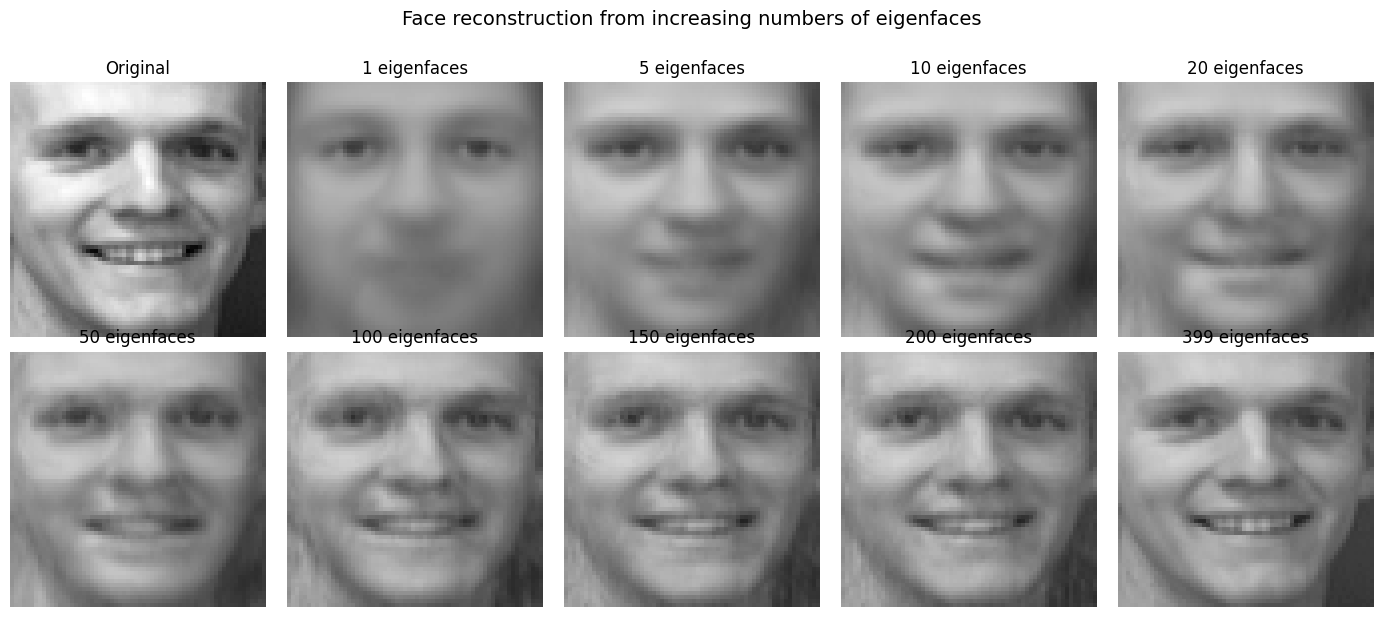

In [85]:
# Reconstruct a single face using increasing numbers of eigenfaces
test_idx = 42  # pick a face to reconstruct
test_face = faces_centered[test_idx, :]  # already mean-subtracted

# Project onto eigenfaces to get coefficients: c_k = u_k^T @ face
coeffs = U_faces.T @ test_face  # all coefficients

fig, axes = plt.subplots(2, 5, figsize=(14, 6))

# Original face
axes[0, 0].imshow(faces[test_idx].reshape(img_h, img_w), cmap="gray")
axes[0, 0].set_title("Original")
axes[0, 0].axis("off")

# Reconstructions with r eigenfaces
recon_ranks = [1, 5, 10, 20, 50, 100, 150, 200, 399]
for i, r in enumerate(recon_ranks):
    row, col = divmod(i + 1, 5)
    reconstructed = mean_face + U_faces[:, :r] @ coeffs[:r]
    axes[row, col].imshow(reconstructed.reshape(img_h, img_w), cmap="gray",
                          vmin=0, vmax=1)
    axes[row, col].set_title(f"{r} eigenfaces")
    axes[row, col].axis("off")

plt.suptitle("Face reconstruction from increasing numbers of eigenfaces",
             fontsize=14, y=1.02)
plt.tight_layout()

The eigenfaces example drives home the same point as the synthetic data example earlier: the SVD finds a hierarchical set of patterns, and a truncated reconstruction captures the essential structure while discarding noise and fine-grained detail.

In the next notebook, we will do *exactly* the same thing with sea surface temperature fields. Instead of "eigenfaces," the spatial patterns will be called **Empirical Orthogonal Functions (EOFs)**, and instead of face-to-face variation, we will study month-to-month climate variability. The mathematics is identical.

## Application 3: The SVD and Regression

The SVD is not just for decomposition and compression — it also provides the cleanest route to solving **least-squares regression** problems. As discussed in Chapters 1 and 4 of *Data-Driven Science and Engineering* (Brunton & Kutz), the SVD gives us the **pseudoinverse**, which in turn gives us the least-squares solution.

### The pseudoinverse

Given $\mathbf{A} = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$, the **Moore-Penrose pseudoinverse** is:

$$
\mathbf{A}^+ = \mathbf{V} \boldsymbol{\Sigma}^+ \mathbf{U}^T
$$

where $\boldsymbol{\Sigma}^+$ is formed by taking the reciprocal of each non-zero singular value. The pseudoinverse solves the least-squares problem:

$$
\min_{\mathbf{x}} \|\mathbf{A}\mathbf{x} - \mathbf{b}\|_2 \quad \Longrightarrow \quad \hat{\mathbf{x}} = \mathbf{A}^+ \mathbf{b}
$$

This is the solution to linear regression! When we fit a linear model $\mathbf{y} = \mathbf{A}\boldsymbol{\beta}$, the least-squares coefficients are $\hat{\boldsymbol{\beta}} = \mathbf{A}^+ \mathbf{y}$.

### Why the SVD matters for regression

The SVD-based pseudoinverse is more numerically stable than the normal equations ($\hat{\boldsymbol{\beta}} = (\mathbf{A}^T\mathbf{A})^{-1}\mathbf{A}^T\mathbf{y}$) because:
- It avoids forming $\mathbf{A}^T\mathbf{A}$, which squares the condition number
- It handles rank-deficient (collinear) design matrices gracefully by ignoring near-zero singular values
- It directly reveals which directions in the predictor space are well-determined vs. poorly-determined

In [86]:
# Example: Polynomial regression via the SVD
rng = np.random.default_rng(0)

# Generate noisy data from a cubic polynomial
t_reg = np.linspace(0, 1, 50)
y_true = 2 - 3 * t_reg + 4 * t_reg**2 - 1.5 * t_reg**3
y_noisy = y_true + 0.15 * rng.standard_normal(len(t_reg))

# Build the Vandermonde (design) matrix for polynomial degree 3
degree = 3
A_reg = np.column_stack([t_reg**k for k in range(degree + 1)])
print(f"Design matrix A shape: {A_reg.shape}")

# Method 1: SVD-based pseudoinverse
U_reg, s_reg, Vt_reg = np.linalg.svd(A_reg, full_matrices=False)
print(f"Singular values of A: {s_reg}")
print(f"Condition number: {s_reg[0] / s_reg[-1]:.1f}")

# Pseudoinverse: A+ = V Sigma+ U^T
Sigma_plus = np.diag(1.0 / s_reg)
beta_svd = Vt_reg.T @ Sigma_plus @ U_reg.T @ y_noisy

# Method 2: numpy's lstsq (also uses SVD internally)
beta_lstsq, _, _, _ = np.linalg.lstsq(A_reg, y_noisy, rcond=None)

print(f"\nTrue coefficients:      [2.0, -3.0, 4.0, -1.5]")
print(f"SVD pseudoinverse:      {beta_svd}")
print(f"np.linalg.lstsq:       {beta_lstsq}")
print(f"Difference:             {np.linalg.norm(beta_svd - beta_lstsq):.2e}")

Design matrix A shape: (50, 4)
Singular values of A: [8.6887 2.9651 0.6018 0.0737]
Condition number: 117.9

True coefficients:      [2.0, -3.0, 4.0, -1.5]
SVD pseudoinverse:      [ 2.0262 -3.3339  4.31   -1.2815]
np.linalg.lstsq:       [ 2.0262 -3.3339  4.31   -1.2815]
Difference:             4.49e-15


Well-conditioned: condition number = 117.9
Near-collinear:   condition number = 61107.7


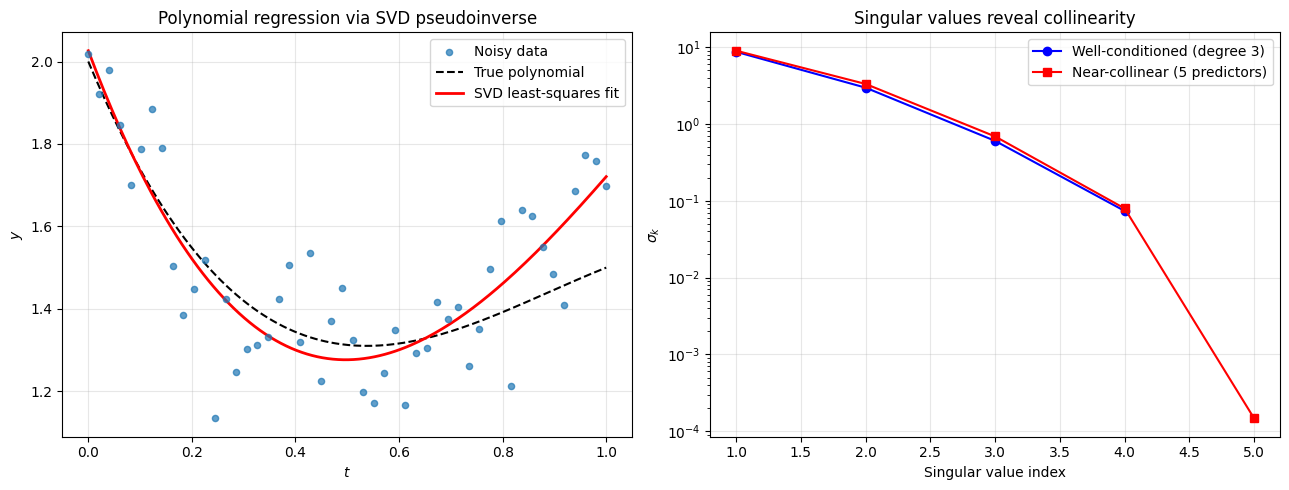

In [87]:
# Visualize the regression fit
t_fine = np.linspace(0, 1, 200)
A_fine = np.column_stack([t_fine**k for k in range(degree + 1)])
y_fit = A_fine @ beta_svd

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: the fit
axes[0].scatter(t_reg, y_noisy, s=20, alpha=0.7, label="Noisy data", zorder=3)
axes[0].plot(t_fine, A_fine @ [2, -3, 4, -1.5], 'k--', label="True polynomial", linewidth=1.5)
axes[0].plot(t_fine, y_fit, 'r-', label="SVD least-squares fit", linewidth=2)
axes[0].set_xlabel("$t$")
axes[0].set_ylabel("$y$")
axes[0].set_title("Polynomial regression via SVD pseudoinverse")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: what happens with a near-singular design matrix?
# Add a nearly collinear column (t^3 ≈ t^2 * t, so t^3.01 is nearly redundant)
A_bad = np.column_stack([t_reg**0, t_reg, t_reg**2, t_reg**3, t_reg**3.01])
U_bad, s_bad, Vt_bad = np.linalg.svd(A_bad, full_matrices=False)

axes[1].semilogy(np.arange(1, len(s_reg) + 1), s_reg, 'bo-', label="Well-conditioned (degree 3)")
axes[1].semilogy(np.arange(1, len(s_bad) + 1), s_bad, 'rs-', label="Near-collinear (5 predictors)")
axes[1].set_xlabel("Singular value index")
axes[1].set_ylabel("$\\sigma_k$")
axes[1].set_title("Singular values reveal collinearity")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
print(f"Well-conditioned: condition number = {s_reg[0]/s_reg[-1]:.1f}")
print(f"Near-collinear:   condition number = {s_bad[0]/s_bad[-1]:.1f}")

### Truncated SVD regression: regularization for free

A powerful technique is to use the **truncated** SVD pseudoinverse for regression. By keeping only the first $r$ singular values, we ignore directions in the predictor space that are poorly determined by the data. This acts as a form of **regularization**, similar in spirit to ridge regression.

This connects directly to dimensionality reduction: we can first reduce our predictors using PCA (keeping the top $r$ principal components), then regress on those components. This is called **Principal Component Regression (PCR)** — a technique widely used in chemometrics, remote sensing, and climate science.

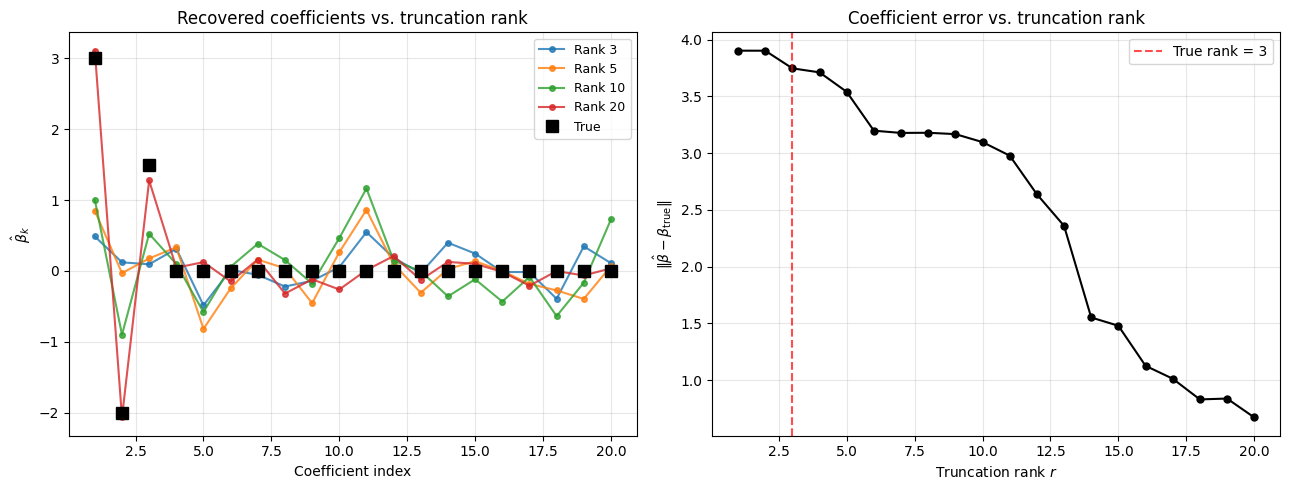

In [88]:
# Demonstrate truncated SVD regression on a noisy, high-dimensional problem
rng = np.random.default_rng(42)

n_obs = 30
n_features = 20

# Create predictors with decaying importance
A_hd = rng.standard_normal((n_obs, n_features))
# True coefficients: only the first 3 features matter
beta_true = np.zeros(n_features)
beta_true[:3] = [3.0, -2.0, 1.5]

y_hd = A_hd @ beta_true + 0.5 * rng.standard_normal(n_obs)

# Full SVD regression (all 20 modes)
U_hd, s_hd, Vt_hd = np.linalg.svd(A_hd, full_matrices=False)

# Compare full vs. truncated pseudoinverse
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: recovered coefficients for different truncation ranks
for r in [3, 5, 10, 20]:
    Sigma_plus_r = np.diag(np.concatenate([1.0 / s_hd[:r], np.zeros(len(s_hd) - r)]))
    beta_r = Vt_hd.T @ Sigma_plus_r @ U_hd.T @ y_hd
    axes[0].plot(np.arange(1, n_features + 1), beta_r, 'o-', markersize=4,
                 label=f"Rank {r}", alpha=0.8)

axes[0].plot(np.arange(1, n_features + 1), beta_true, 'ks', markersize=8,
             label="True", zorder=5)
axes[0].set_xlabel("Coefficient index")
axes[0].set_ylabel("$\\hat{\\beta}_k$")
axes[0].set_title("Recovered coefficients vs. truncation rank")
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Right: prediction error vs. truncation rank
errors = []
for r in range(1, n_features + 1):
    Sigma_plus_r = np.diag(np.concatenate([1.0 / s_hd[:r], np.zeros(len(s_hd) - r)]))
    beta_r = Vt_hd.T @ Sigma_plus_r @ U_hd.T @ y_hd
    errors.append(np.linalg.norm(beta_r - beta_true))

axes[1].plot(range(1, n_features + 1), errors, 'ko-', markersize=5)
axes[1].axvline(3, color='r', linestyle='--', alpha=0.7, label="True rank = 3")
axes[1].set_xlabel("Truncation rank $r$")
axes[1].set_ylabel("$\\|\\hat{\\beta} - \\beta_{\\mathrm{true}}\\|$")
axes[1].set_title("Coefficient error vs. truncation rank")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

Notice that the truncated pseudoinverse at rank 3 (the true rank of the signal) gives the **best** coefficient recovery — using more modes actually introduces noise into the estimate. This is the bias-variance tradeoff at work: fewer modes = more bias but less variance; more modes = less bias but more variance.

This principle appears throughout Earth science:
- **Statistical downscaling**: Regress local weather variables on the leading PCs of large-scale circulation patterns
- **Paleoclimate reconstruction**: Regress proxy records (tree rings, ice cores) on EOFs of instrumental temperature fields
- **Empirical prediction**: Use leading PCs of SST as predictors for seasonal rainfall forecasts

In all these cases, truncating the SVD/PCA to a few leading modes acts as a built-in regularizer, improving the stability and generalization of the regression.

## Looking Ahead

In the next notebook, we apply the SVD to real global sea surface temperature data. The procedure follows the same steps used in the eigenfaces example: subtract the mean field (computing "anomalies"), reshape the data into a 2D matrix, and call `np.linalg.svd`. The left singular vectors become spatial maps called **Empirical Orthogonal Functions (EOFs)**, the weighted right singular vectors become time series called **Principal Components (PCs)**, and the singular values quantify how much variance each mode explains. The leading modes turn out to correspond to well-known climate phenomena like ENSO. We also verify numerically that this SVD-based approach, the classical covariance-matrix eigendecomposition, and `sklearn.decomposition.PCA` all produce identical results.